# Import Library

In [38]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression        # GLR ~ Gaussian(identity)
from sklearn.tree import DecisionTreeRegressor           # Decision Tree (regression)
from sklearn.ensemble import RandomForestRegressor       # Random Forest Regression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.inspection import permutation_importance
import joblib
from datetime import datetime
import json
import warnings
import seaborn as sns
warnings.filterwarnings("ignore", category=UserWarning)


# Load Dataset


In [39]:

# Load dataset
data_path = Path("data") / "Student_performance_data_kaggle.csv"
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
display(df.head())

Dataset shape: (2392, 15)

Data types:
StudentID              int64
Age                    int64
Gender                 int64
Ethnicity              int64
ParentalEducation      int64
StudyTimeWeekly      float64
Absences               int64
Tutoring               int64
ParentalSupport        int64
Extracurricular        int64
Sports                 int64
Music                  int64
Volunteering           int64
GPA                  float64
GradeClass             int64
dtype: object


,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4


# Preprocessing

In [40]:
# Configuration
TARGET = "GPA"
DROP_COLS = ["StudentID", "GradeClass"]
NUM_COLS = ["Age", "StudyTimeWeekly", "Absences"]
TEST_SIZE = 0.30
RANDOM_STATE = 42

# 1) Drop unnecessary columns and prepare data
df = df.drop(columns=DROP_COLS, errors="ignore")
X = df.drop(columns=[TARGET])
y = df[TARGET]

# 2) Remove rows with missing values (complete-case analysis)
df_clean = pd.concat([X, y], axis=1).dropna()
X = df_clean.drop(columns=[TARGET])
y = df_clean[TARGET]

# 3) Define categorical columns
cat_cols = [c for c in X.columns if c not in NUM_COLS]

# 4) Create preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_COLS),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop"
)

# 5) Train-test split (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

# 6) Fit and transform data
X_train_t = preprocessor.fit_transform(X_train)
X_test_t = preprocessor.transform(X_test)
feature_names = preprocessor.get_feature_names_out()

# 7) Create DataFrames with transformed data
X_train_df = pd.DataFrame(X_train_t, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_t, columns=feature_names, index=X_test.index)

# 8) Display summary
print(f"Target: {TARGET}")
print(f"Train: {X_train_df.shape} | Test: {X_test_df.shape}")
print(f"Numeric columns: {NUM_COLS}")
print(f"Categorical columns: {cat_cols[:10]}{'...' if len(cat_cols) > 10 else ''}")
print("\nPreview X_train:")
display(X_train_df.head())

# 9) Save processed data
X_train_df.to_csv("X_train.csv", index=False)
X_test_df.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

Target: GPA
Train: (1674, 29) | Test: (718, 29)
Numeric columns: ['Age', 'StudyTimeWeekly', 'Absences']
Categorical columns: ['Gender', 'Ethnicity', 'ParentalEducation', 'Tutoring', 'ParentalSupport', 'Extracurricular', 'Sports', 'Music', 'Volunteering']

Preview X_train:


,num__Age,num__StudyTimeWeekly,num__Absences,cat__Gender_0,cat__Gender_1,cat__Ethnicity_0,cat__Ethnicity_1,cat__Ethnicity_2,cat__Ethnicity_3,cat__ParentalEducation_0,...,cat__ParentalSupport_3,cat__ParentalSupport_4,cat__Extracurricular_0,cat__Extracurricular_1,cat__Sports_0,cat__Sports_1,cat__Music_0,cat__Music_1,cat__Volunteering_0,cat__Volunteering_1
380,1.370573,-1.037048,-0.900446,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
226,-1.307644,0.306723,0.516788,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1075,-1.307644,1.728657,-0.191829,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
715,1.370573,0.065691,0.634891,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1822,1.370573,-1.319643,1.697817,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0


In [41]:
# Correlation analysis: GPA vs features (TRAIN set)
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")

# Combine features and target
df_tr = X_train.copy()
df_tr["GPA"] = pd.to_numeric(y_train, errors="coerce")

# Remove constant columns
const_cols = df_tr.columns[df_tr.nunique(dropna=True) <= 1]
if len(const_cols) > 0:
    df_tr = df_tr.drop(columns=const_cols)

# Calculate correlations
num_df = df_tr.select_dtypes(include=[np.number])
corr = pd.DataFrame({
    "Pearson_r": num_df.corr(method="pearson")["GPA"].drop("GPA"),
    "Spearman_rho": num_df.corr(method="spearman")["GPA"].drop("GPA")
})

# Add absolute values and sort
corr["|Pearson_r|"] = corr["Pearson_r"].abs()
corr["|Spearman_rho|"] = corr["Spearman_rho"].abs()
corr = corr.sort_values(["|Pearson_r|", "|Spearman_rho|"], ascending=False)

# Save and display
corr.to_csv("corr_GPA_vs_features_train.csv")
display(corr.head(12))

,Pearson_r,Spearman_rho,|Pearson_r|,|Spearman_rho|
num__Absences,-0.917324,-0.923715,0.917324,0.923715
num__StudyTimeWeekly,0.201821,0.190983,0.201821,0.190983
cat__Tutoring_0,-0.144424,-0.134647,0.144424,0.134647
cat__Tutoring_1,0.144424,0.134647,0.144424,0.134647
cat__ParentalSupport_0,-0.120022,-0.112333,0.120022,0.112333
cat__ParentalSupport_4,0.099483,0.089263,0.099483,0.089263
cat__Music_0,-0.090424,-0.087004,0.090424,0.087004
cat__Music_1,0.090424,0.087004,0.090424,0.087004
cat__ParentalSupport_3,0.082795,0.077658,0.082795,0.077658
cat__Extracurricular_0,-0.076706,-0.069638,0.076706,0.069638


# Model Building

## Decision Tree

Data shapes: Train=(1674, 29), Test=(718, 29)

=== Decision Tree — TEST Metrics ===
R²   : 0.8546
RMSE : 0.3499
MAE  : 0.2822
MSE  : 0.1225


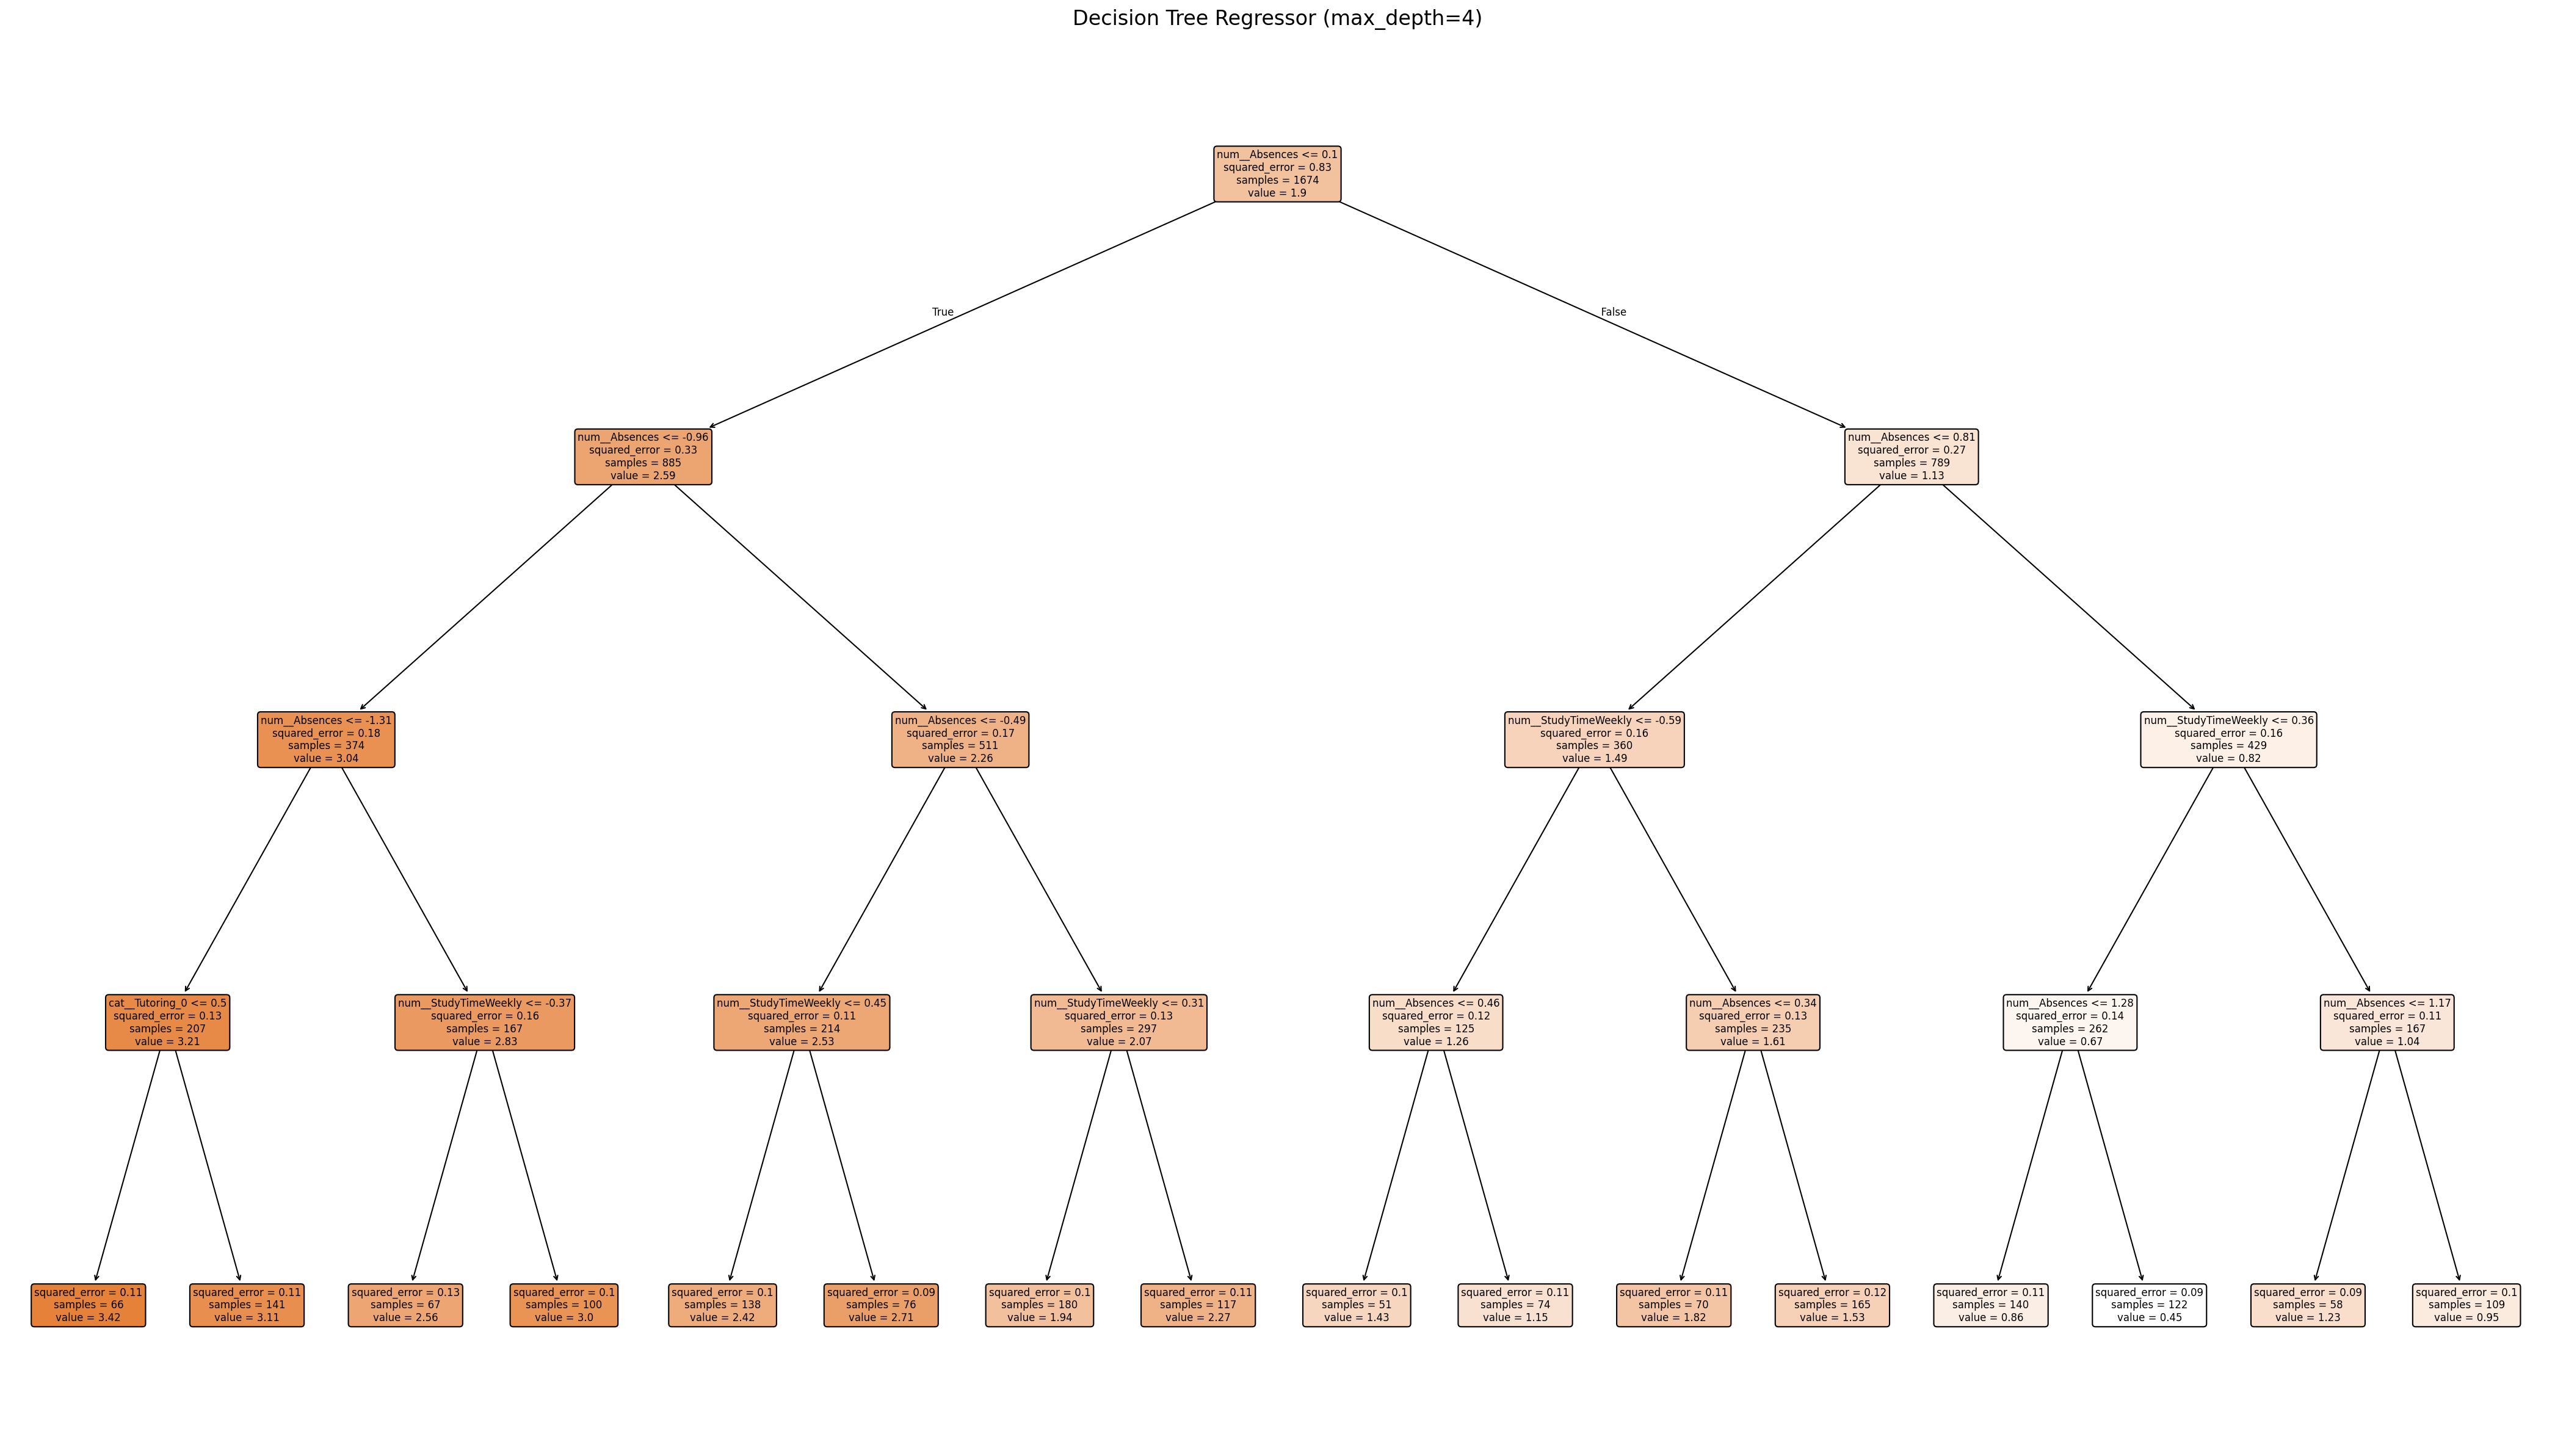

In [42]:
# Decision Tree Regressor
# Setup directories
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
for folder in ["metrics", "figures", "predictions"]:
    Path(folder).mkdir(exist_ok=True)

# Load data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze("columns")

print(f"Data shapes: Train={X_train.shape}, Test={X_test.shape}")

# Train model
dt = DecisionTreeRegressor(
    random_state=42,
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5
)
dt.fit(X_train, y_train)

# Evaluate on test set
y_pred = dt.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Decision Tree — TEST Metrics ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")

# Save metrics to JSON
metrics = {
    "model": "DecisionTreeRegressor",
    "params": {
        "max_depth": 4,
        "min_samples_split": 10,
        "min_samples_leaf": 5,
        "random_state": 42
    },
    "test": {
        "R-squared": float(r2),
        "RMSE": float(rmse),
        "MAE": float(mae),
        "MSE": float(mse)
    },
    "n_train": len(X_train),
    "n_test": len(X_test),
    "timestamp": stamp
}
with open(f"metrics/DT_test_metrics_{stamp}.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Visualize tree
fig, ax = plt.subplots(figsize=(28, 16), dpi=150)
plot_tree(
    dt,
    feature_names=list(X_train.columns),
    filled=True,
    rounded=True,
    impurity=True,
    precision=2,
    fontsize=8,
    ax=ax
)
ax.set_title("Decision Tree Regressor (max_depth=4)", fontsize=16)
plt.tight_layout()
plt.savefig(f"figures/decision_tree_{stamp}.png")
plt.show()

## Generalized Linear Regression


=== Generalized Linear Regression — TEST Metrics ===
R²   : 0.9556
RMSE : 0.1934
MAE  : 0.1546
MSE  : 0.0374


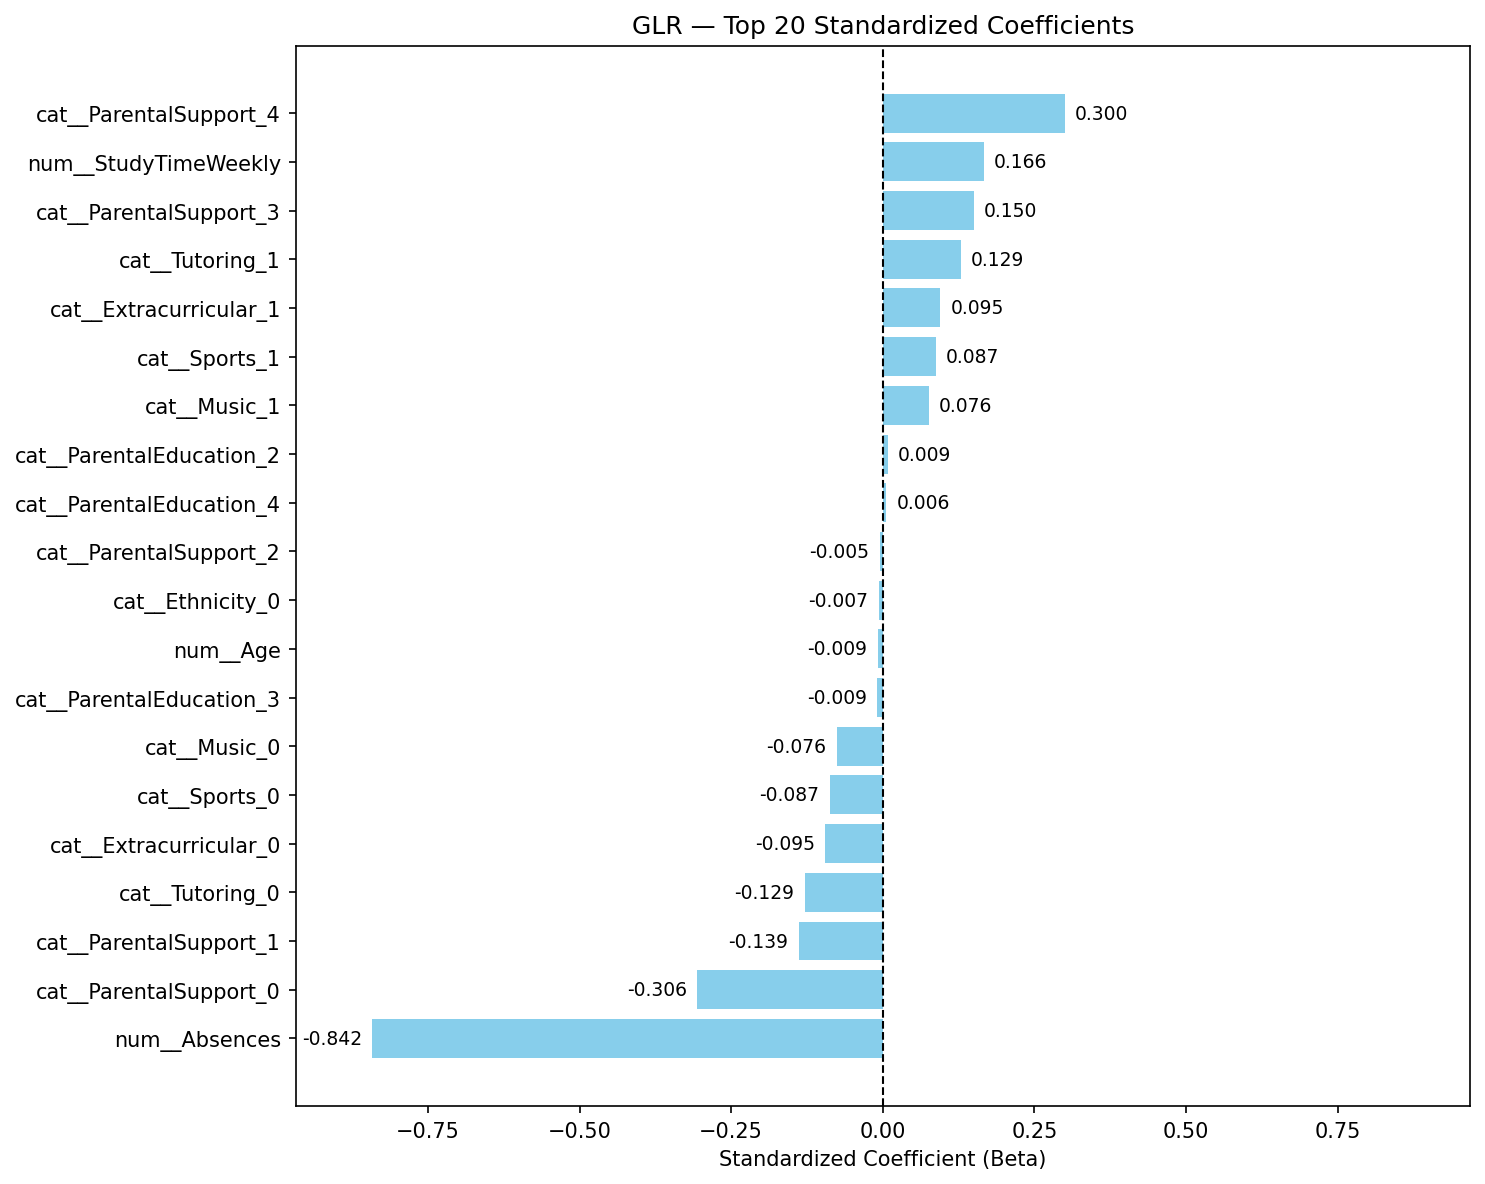

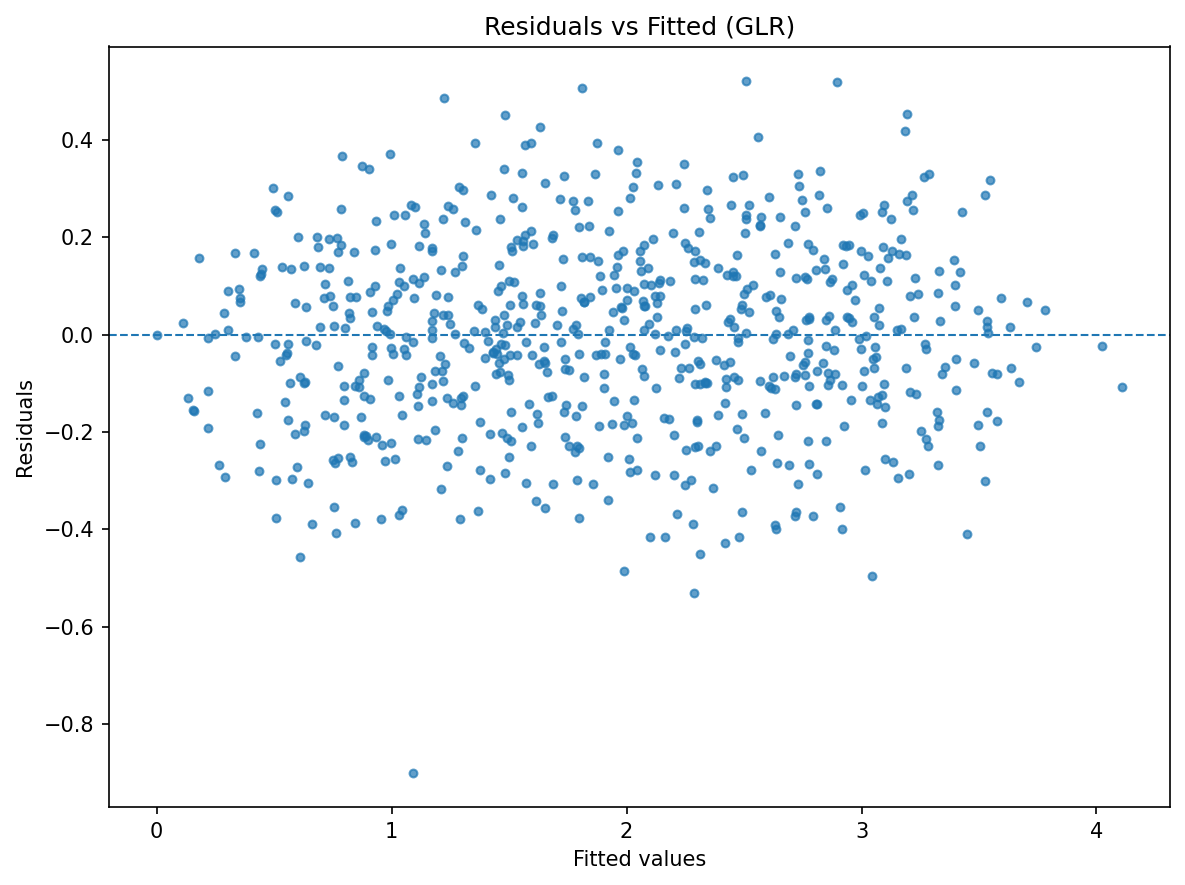

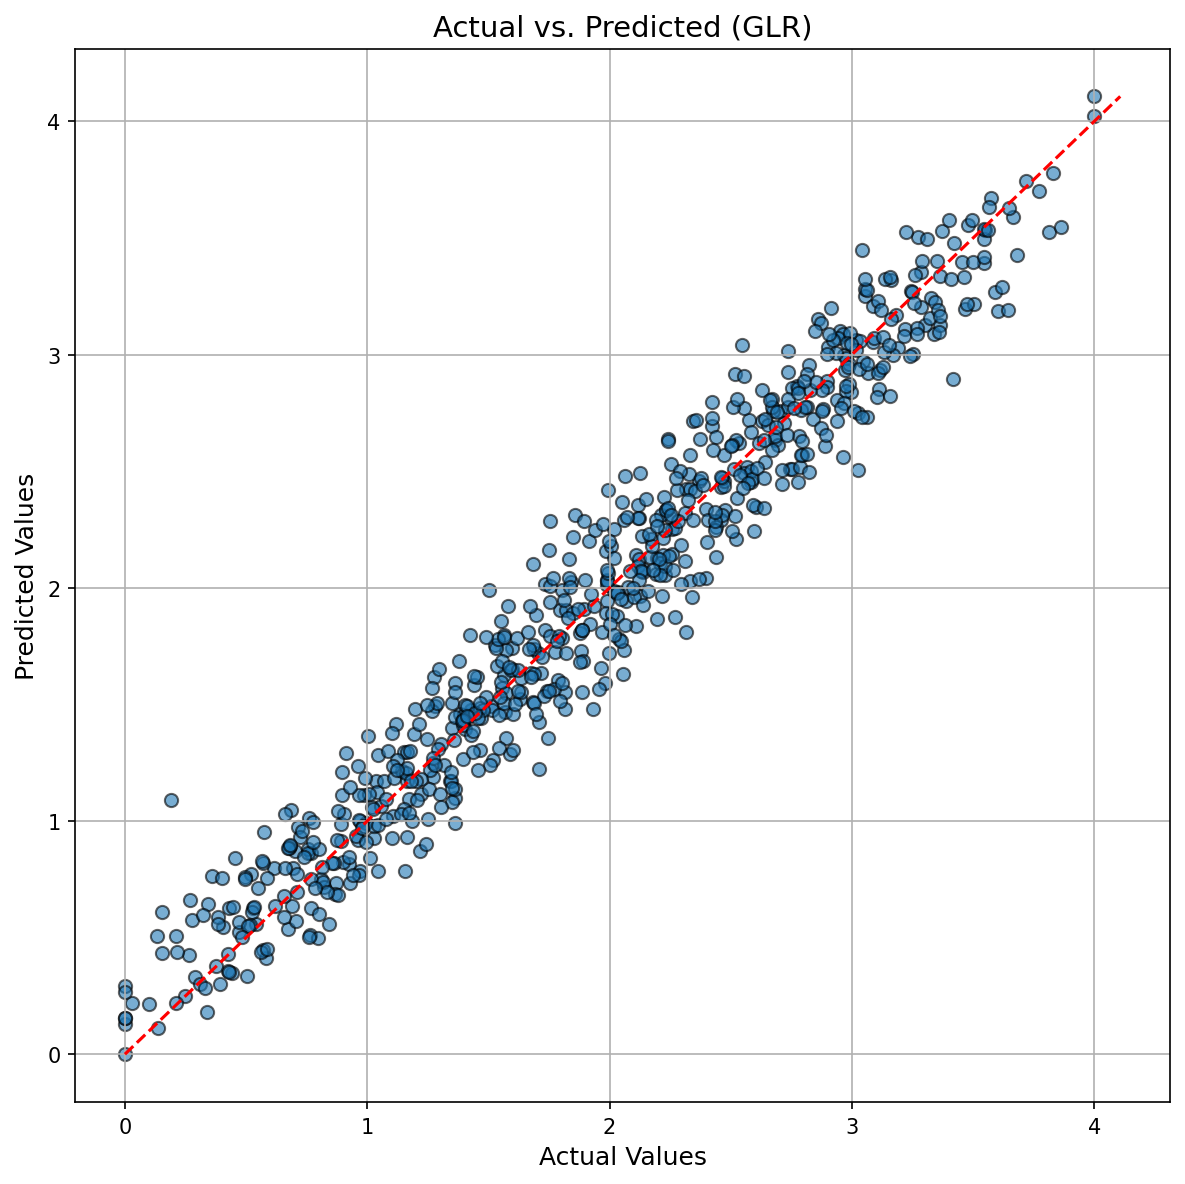

In [43]:
# Generalized Linear Regression
# Setup
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
for folder in ["figures", "metrics", "predictions"]:
    Path(folder).mkdir(exist_ok=True)

# Load data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze("columns")

# Train and predict
lr = LinearRegression().fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print("\n=== Generalized Linear Regression — TEST Metrics ===")
print(f"R²   : {r2:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")

# Save metrics to JSON
metrics = {
    "model": "LinearRegression",
    "params": {},
    "test": {
        "R-squared": float(r2),
        "RMSE": float(rmse),
        "MAE": float(mae),
        "MSE": float(mse)
    },
    "n_train": len(X_train),
    "n_test": len(X_test),
    "timestamp": stamp
}
with open(f"metrics/GLR_test_metrics_{stamp}.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Save predictions to CSV
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "residual": y_test.values - y_pred
})
pred_df.to_csv(f"predictions/GLR_test_predictions_{stamp}.csv", index=False)

# Feature importance (coefficients)
beta_table = (
    pd.DataFrame({"feature": X_train.columns, "beta": lr.coef_})
    .assign(beta_abs=lambda x: x["beta"].abs())
    .sort_values("beta_abs", ascending=False)
    .drop(columns="beta_abs")
)

# Plot 1: Top coefficients
TOP_N = min(20, len(beta_table))
top_plot = beta_table.head(TOP_N).sort_values("beta")

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
bars = ax.barh(top_plot["feature"], top_plot["beta"], color="skyblue")
ax.axvline(0, linestyle="--", linewidth=1, color="black")
ax.set_title(f"GLR — Top {TOP_N} Standardized Coefficients")
ax.set_xlabel("Standardized Coefficient (Beta)")

max_abs = top_plot["beta"].abs().max()
ax.set_xlim(-max_abs * 1.15, max_abs * 1.15)

for rect, val in zip(bars, top_plot["beta"]):
    x = rect.get_width()
    offset = 0.02 * max_abs * (1 if x >= 0 else -1)
    ax.text(
        x + offset,
        rect.get_y() + rect.get_height() / 2,
        f"{val:.3f}",
        va="center",
        ha="left" if x >= 0 else "right",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(f"figures/GLR_top{TOP_N}_standardized_betas_{stamp}.png")
plt.show()

# Plot 2: Residuals vs Fitted
residuals = y_test.values - y_pred

fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.scatter(y_pred, residuals, s=14, alpha=0.7)
ax.axhline(0, linestyle="--", linewidth=1)
ax.set_title("Residuals vs Fitted (GLR)")
ax.set_xlabel("Fitted values")
ax.set_ylabel("Residuals")
plt.tight_layout()
plt.savefig(f"figures/GLR_residuals_{stamp}.png")
plt.show()

# Plot 3: Actual vs Predicted
fig, ax = plt.subplots(figsize=(8, 8), dpi=150)
ax.scatter(y_test, y_pred, alpha=0.6, edgecolors="k", s=40)

lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, "r--")
ax.set_xlabel("Actual Values", fontsize=12)
ax.set_ylabel("Predicted Values", fontsize=12)
ax.set_title("Actual vs. Predicted (GLR)", fontsize=14)
ax.grid(True)
plt.tight_layout()
plt.savefig(f"figures/GLR_actual_vs_predicted_{stamp}.png")
plt.show()

## Random Forest Regressor


=== Random Forest — TEST Metrics ===
R²   : 0.7685
RMSE : 0.4415
MAE  : 0.3512
MSE  : 0.1949

Top 10 Feature Importances:
                 feature  importance
           num__Absences      0.5284
    num__StudyTimeWeekly      0.1165
                num__Age      0.0442
        cat__Ethnicity_0      0.0147
cat__ParentalEducation_2      0.0146
         cat__Tutoring_0      0.0145
  cat__ParentalSupport_3      0.0143
         cat__Tutoring_1      0.0143
cat__ParentalEducation_1      0.0139
           cat__Gender_1      0.0139


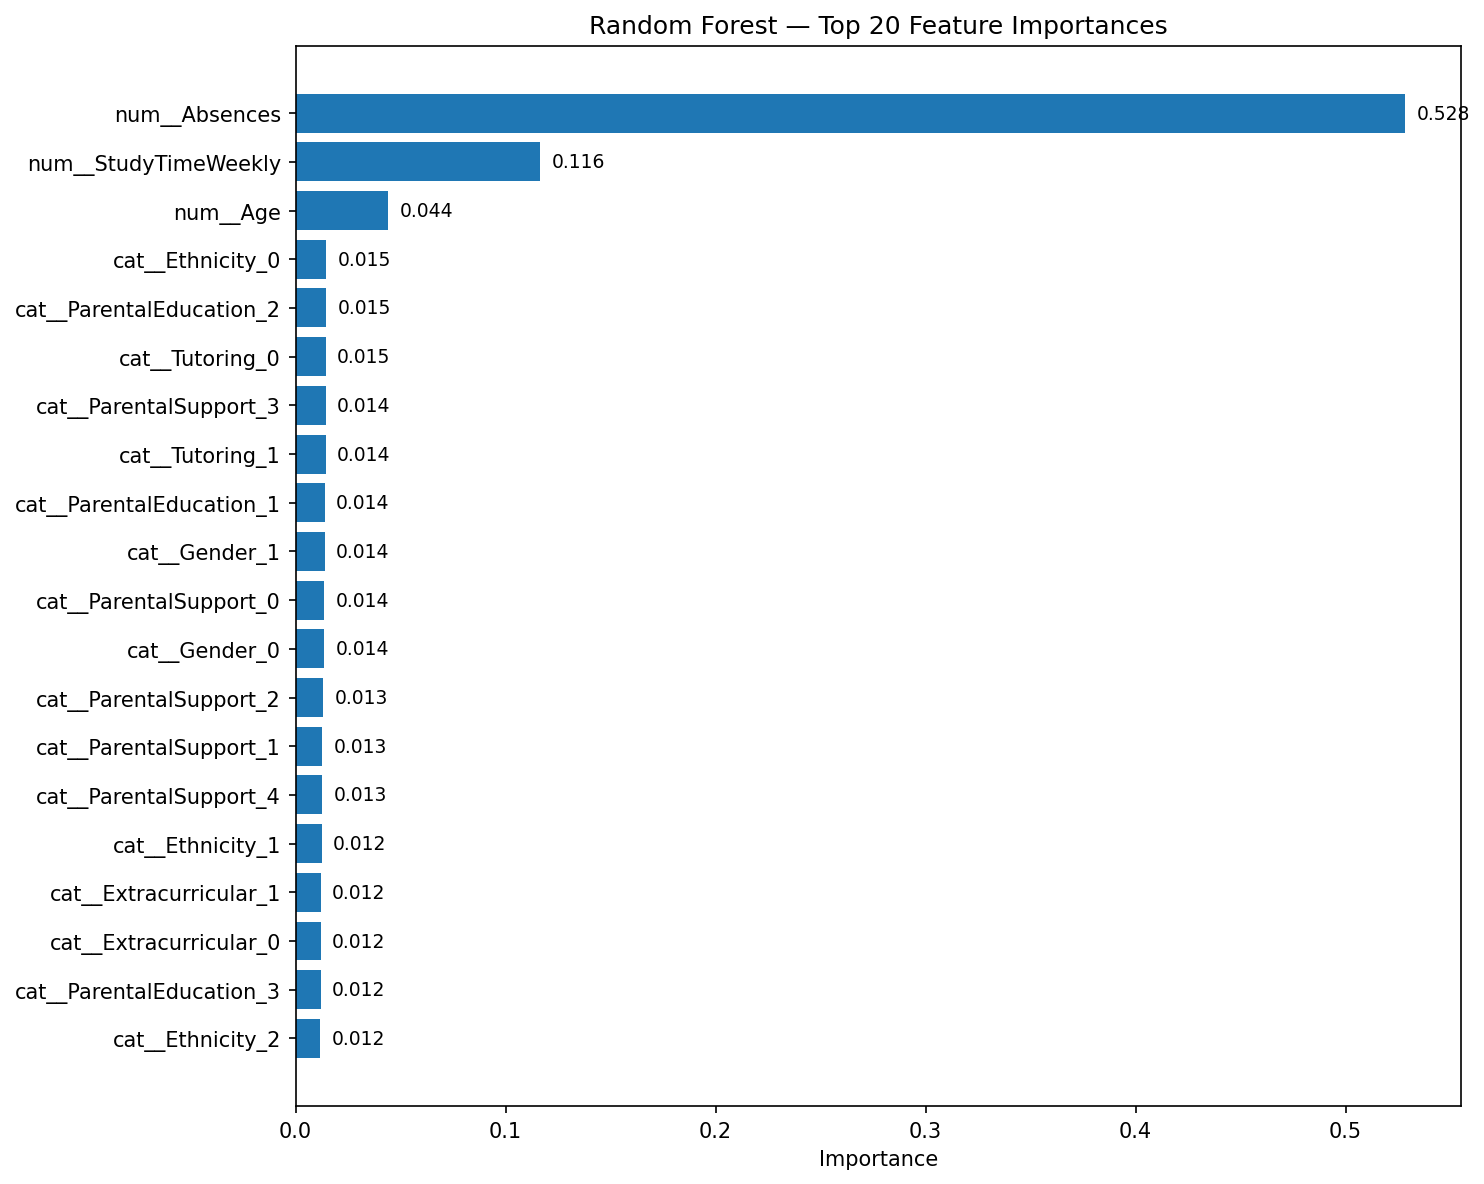

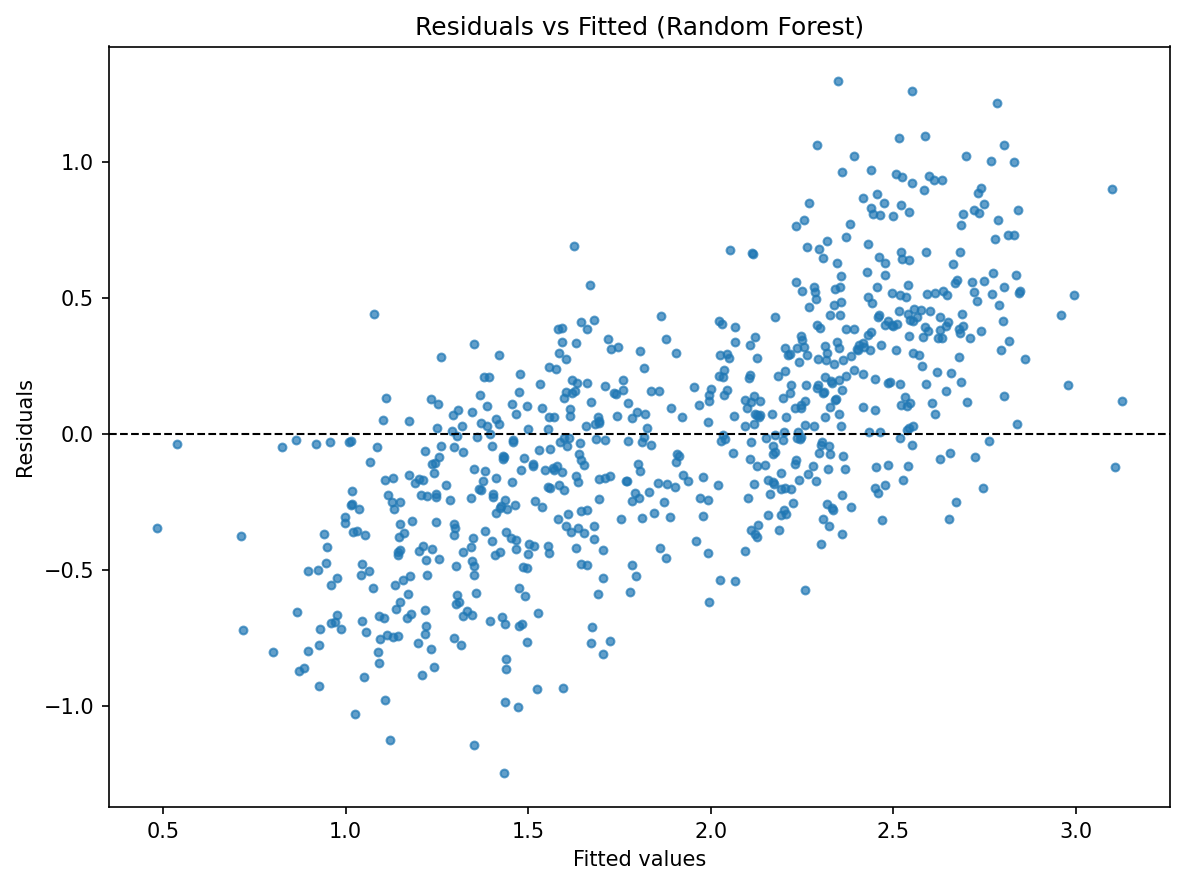

In [44]:
# Random Forest Regressor
# Setup directories
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
for folder in ["predictions", "metrics", "figures"]:
    Path(folder).mkdir(exist_ok=True)

# Load data
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv").squeeze("columns")
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv").squeeze("columns")

# Train model
rf = RandomForestRegressor(
    n_estimators=1000,
    max_features=3,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("\n=== Random Forest — TEST Metrics ===")
print(f"R²   : {r2_score(y_test, y_pred):.4f}")
print(f"RMSE : {np.sqrt(mse):.4f}")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.4f}")
print(f"MSE  : {mse:.4f}")

# Feature importances
imp_table = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

print("\nTop 10 Feature Importances:")
print(imp_table.head(10).to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# Save outputs
# 1) Predictions CSV
pred_df = pd.DataFrame({
    "y_true": y_test.values,
    "y_pred": y_pred,
    "residual": y_test.values - y_pred
})
pred_df.to_csv(f"predictions/RF_test_predictions_{stamp}.csv", index=False)

# 2) Metrics JSON
metrics = {
    "model": "RandomForestRegressor",
    "params": {"n_estimators": 1000, "max_features": 3, "random_state": 42},
    "test": {
        "R-squared": float(r2_score(y_test, y_pred)),
        "RMSE": float(np.sqrt(mse)),
        "MAE": float(mean_absolute_error(y_test, y_pred)),
        "MSE": float(mse)
    },
    "n_train": len(X_train),
    "n_test": len(X_test),
    "timestamp": stamp
}
with open(f"metrics/RF_test_metrics_{stamp}.json", "w") as f:
    json.dump(metrics, f, indent=2)

# Plot 1: Top feature importances
TOP_N = min(20, len(imp_table))
top_imp = imp_table.head(TOP_N).sort_values("importance")

fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
bars = ax.barh(top_imp["feature"], top_imp["importance"])
ax.set_title(f"Random Forest — Top {TOP_N} Feature Importances")
ax.set_xlabel("Importance")

for rect, val in zip(bars, top_imp["importance"]):
    ax.text(
        rect.get_width() + imp_table["importance"].max() * 0.01,
        rect.get_y() + rect.get_height() / 2,
        f"{val:.3f}",
        va="center",
        ha="left",
        fontsize=9,
    )

plt.tight_layout()
plt.savefig(f"figures/RF_top{TOP_N}_feature_importances_{stamp}.png")
plt.show()

# Plot 2: Residuals vs Fitted
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
ax.scatter(y_pred, y_test.values - y_pred, s=14, alpha=0.7)
ax.axhline(0, linestyle="--", linewidth=1, color="black")
ax.set_title("Residuals vs Fitted (Random Forest)")
ax.set_xlabel("Fitted values")
ax.set_ylabel("Residuals")
plt.tight_layout()
plt.savefig(f"figures/RF_residuals_{stamp}.png")
plt.show()

# Comparison

In [45]:
# Results comparison: Your results vs Paper results
import glob

# Paper results from the study (predicting MATH score)
paper_results = {
    "GLR": {'R-squared': 0.792, 'RMSE': 10.49, 'MAE': 8.11, 'MSE': 110.04},
    "Random Forest": {'R-squared': 0.783, 'RMSE': 10.67, 'MAE': 8.33, 'MSE': 113.95},
    "Decision Tree": {'R-squared': 0.750, 'RMSE': 11.47, 'MAE': 9.04, 'MSE': 131.63}
}

# Load latest metrics from JSON files
def load_latest_metrics(model_prefix):
    """Load the most recent metrics file for a given model"""
    files = sorted(glob.glob(f"metrics/{model_prefix}_test_metrics_*.json"), reverse=True)
    if files:
        with open(files[0], 'r') as f:
            data = json.load(f)
            return data['test']
    return None

# Collect your results from saved JSON files
your_results = {}
model_mapping = {
    'GLR': 'GLR',
    'RF': 'Random Forest',
    'DT': 'Decision Tree'
    
}

for prefix, name in model_mapping.items():
    metrics = load_latest_metrics(prefix)
    if metrics:
        your_results[name] = metrics
    else:
        print(f"Warning: No metrics found for {name}")

# Create comparison DataFrame
if your_results:
    comparison_df = pd.concat(
        [pd.DataFrame(your_results), pd.DataFrame(paper_results)],
        axis=1,
        keys=['Your Results', 'Paper Results']
    ).round(3)
    
    print("\n=== Model Performance Comparison ===")
    display(comparison_df)
else:
    print("Error: No model results found. Please run the models first.")


=== Model Performance Comparison ===


Your Results                             Paper Results  \
                   GLR Random Forest Decision Tree           GLR   
R-squared        0.956         0.769         0.855         0.792   
RMSE             0.193         0.441         0.350        10.490   
MAE              0.155         0.351         0.282         8.110   
MSE              0.037         0.195         0.122       110.040   

                                       
          Random Forest Decision Tree  
R-squared         0.783          0.75  
RMSE             10.670         11.47  
MAE               8.330          9.04  
MSE             113.950        131.63